In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data', shuffle = True, image_size = (Image_size, Image_size), batch_size = Batch_size)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

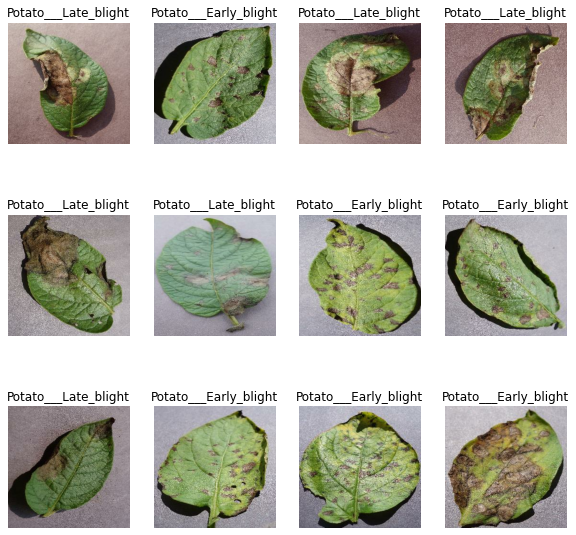

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [6]:
len(dataset)

68

In [7]:
train_ds = dataset.take(54)

In [8]:
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)


In [10]:
val_d = test_ds.take(6)

In [11]:
len(test_ds)

14

In [12]:
def get_dataset_pertitions_tf(ds, train_split=0.8, test_split = 0.1, val_split = 0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_pertitions_tf(dataset)

In [14]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [15]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
input_shape = (Batch_size, Image_size,Image_size, Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (Image_size,Image_size)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'softmax')
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [20]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
history =  model.fit(
    train_ds,
    epochs = Epochs,
    batch_size = Batch_size,
    verbose = 1,
    validation_data = val_ds

)

Epoch 1/50
54/54 [==============================] - 130s 2s/step - loss: 1.2376 - accuracy: 0.4531 - val_loss: 0.8971 - val_accuracy: 0.4286
Epoch 2/50
54/54 [==============================] - 95s 2s/step - loss: 0.8424 - accuracy: 0.6007 - val_loss: 0.8812 - val_accuracy: 0.5238
Epoch 3/50
54/54 [==============================] - 95s 2s/step - loss: 0.7201 - accuracy: 0.6892 - val_loss: 0.5643 - val_accuracy: 0.7976
Epoch 4/50
54/54 [==============================] - 96s 2s/step - loss: 0.5298 - accuracy: 0.7731 - val_loss: 0.3892 - val_accuracy: 0.8571
Epoch 5/50
54/54 [==============================] - 96s 2s/step - loss: 0.3802 - accuracy: 0.8478 - val_loss: 0.2962 - val_accuracy: 0.9107
Epoch 6/50
54/54 [==============================] - 96s 2s/step - loss: 0.2760 - accuracy: 0.8866 - val_loss: 0.2459 - val_accuracy: 0.9107
Epoch 7/50
54/54 [==============================] - 96s 2s/step - loss: 0.2375 - accuracy: 0.9068 - val_loss: 0.2786 - val_accuracy: 0.9048
Epoch 8/50
54/54 [=

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 420ms/step - loss: 0.0300 - accuracy: 0.9844


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

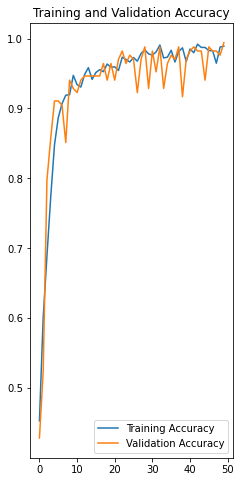

In [24]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first iamge to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 642ms/step
predicted label: Potato___Early_blight


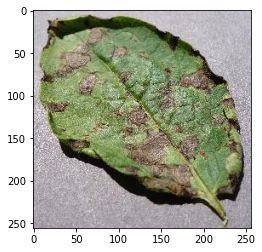

In [25]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first iamge to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


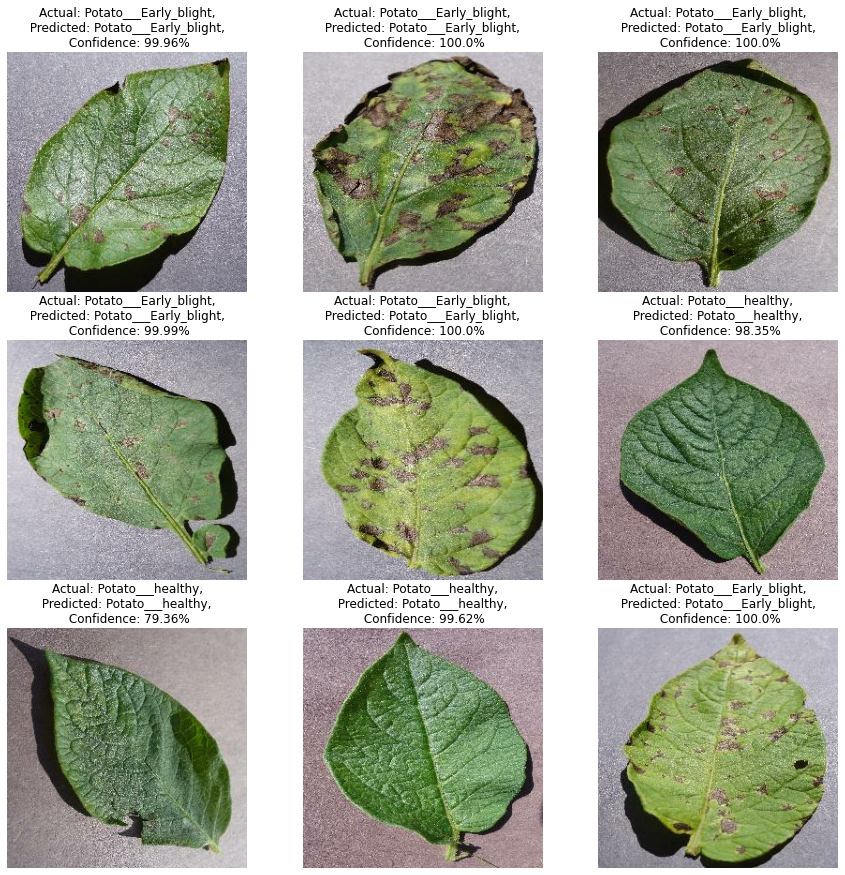

In [27]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis('off')

In [28]:
#model_version = 1
#model.save(f"../Untitled Folder/models/{model_version}")